## Importing Libraries

In [ ]:
# Importing the Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.filterwarnings('ignore')
import nltk
import re
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import spacy


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
exclude_list = ['but','no','because','against','not','than']
stop_words = set(stopwords.words('english'))
stop_words.difference_update(exclude_list)
#punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## preparing data

In [ ]:
df_train = pd.read_csv(r'drugsComTrain_raw.csv')
df_test = pd.read_csv(r'drugsComTest_raw.csv')

print ("The shape of the train set given is : ", df_train.shape)
print ("The shape of the test set given is : ", df_test.shape)

The shape of the train set given is :  (161297, 7)
The shape of the test set given is :  (53766, 7)


In [ ]:
# Merging the test and train data 
df_data = pd.concat([df_train, df_test])

print (df_data.shape)

df_data.head()

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,03-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
df_data.columns = df_data.columns.str.lower()

In [ ]:
df_data.columns

Index(['uniqueid', 'drugname', 'condition', 'review', 'rating', 'date',
       'usefulcount'],
      dtype='object')

## knowing the data

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueid     215063 non-null  int64 
 1   drugname     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulcount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


In [ ]:
cat = []
num = []
for i in df_data.columns:
    if df_data[i].dtypes=='object':
        cat.append(i)
    else:
        num.append(i)
print('number of numeric variables are ',len(num))
print('number of categorical variables are ',len(cat))

number of numeric variables are  3
number of categorical variables are  4


In [ ]:
df_data.describe()

,uniqueid,rating,usefulcount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


## Null value treatment

In [ ]:
df_data.isnull().sum()

uniqueid          0
drugname          0
condition      1194
review            0
rating            0
date              0
usefulcount       0
dtype: int64

In [ ]:
percent_missing = df_data.isnull().sum() * 100 / len(df_data)
missing_value_df = pd.DataFrame({'column_name': df_data.columns, 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
uniqueid,uniqueid,0.000000
drugname,drugname,0.000000
condition,condition,0.555186
review,review,0.000000
rating,rating,0.000000
date,date,0.000000
usefulcount,usefulcount,0.000000


###### condition column has less than 0.6% of data as null, so we can directly drop the null data.

In [ ]:
print('Shape of df before dropping null values ',df_data.shape)
df_data.dropna(inplace=True)
df_data.reset_index(drop=True)
print('Shape of df after dropping null values ',df_data.shape)

Shape of df before dropping null values  (215063, 7)
Shape of df after dropping null values  (213869, 7)


## Converting date related columns to required datatypes

In [ ]:
#date is not in datetime format, need to convert it
df_data['date'] = pd.to_datetime(df_data['date'])

## Inferential Statistics

In [ ]:
df_data.nunique()

uniqueid       213869
drugname         3667
condition         916
review         128449
rating             10
date             3579
usefulcount       397
dtype: int64

In [ ]:
# Some of the conditions that people are suffering with
df_data['condition'].value_counts().head(10)

Birth Control      38436
Depression         12164
Pain                8245
Anxiety             7812
Acne                7435
Bipolar Disorde     5604
Insomnia            4904
Weight Loss         4857
Obesity             4757
ADHD                4509
Name: condition, dtype: int64

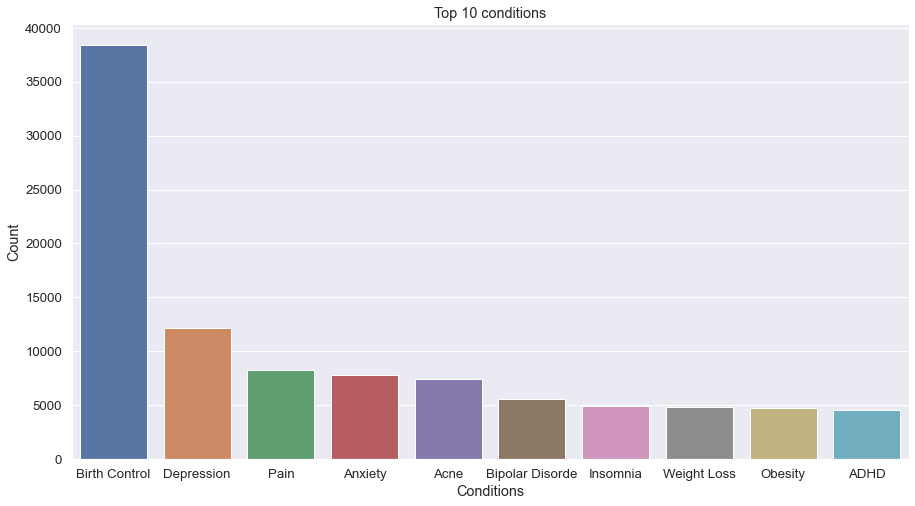

In [ ]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

con = dict(df_data.condition.value_counts()[:10])
fig = sns.barplot(list(con.keys()),list(con.values()))
fig.set_title("Top 10 conditions")
fig.set_xlabel("Conditions")
fig.set_ylabel("Count");

In [ ]:
# Top 10 drugs which got good rating(10)
df_data.loc[df_data['rating'] == 10]['drugname'].value_counts().head(10)

Levonorgestrel                       1883
Phentermine                          1079
Etonogestrel                          864
Varenicline                           662
Ethinyl estradiol / norethindrone     601
Escitalopram                          596
Clonazepam                            586
Alprazolam                            565
Sertraline                            550
Plan B                                527
Name: drugname, dtype: int64

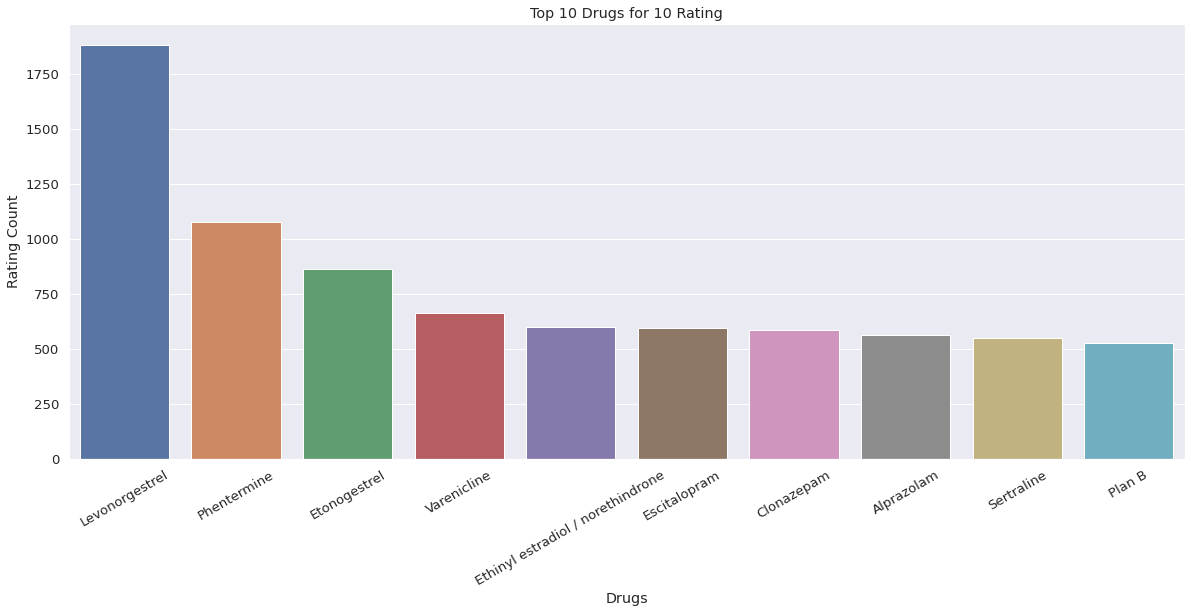

In [ ]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [20, 8]

drugs = dict(df_data.loc[df_data['rating'] == 10]['drugname'].value_counts().head(10))
fig = sns.barplot(list(drugs.keys()),list(drugs.values()))
fig.set_title("Top 10 Drugs for 10 Rating")
fig.set_xlabel("Drugs")
fig.set_ylabel("Rating Count")
fig.set_xticklabels(list(drugs.keys()),rotation=30);

In [ ]:
# 10 drugs which users are not satisfied with and given 1 ating
df_data.loc[df_data['rating'] == 1]['drugname'].value_counts().head(10)

Miconazole                            767
Ethinyl estradiol / norethindrone     728
Etonogestrel                          707
Levonorgestrel                        511
Nexplanon                             504
Ethinyl estradiol / norgestimate      464
Medroxyprogesterone                   443
Depo-Provera                          417
Tioconazole                           410
Ethinyl estradiol / levonorgestrel    385
Name: drugname, dtype: int64

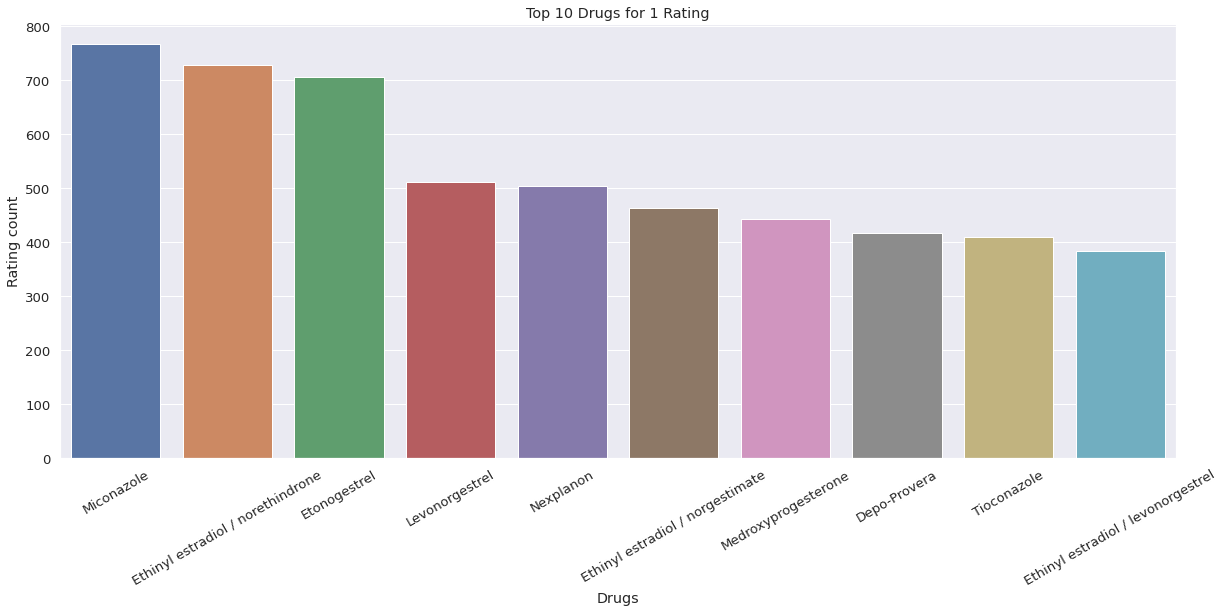

In [ ]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [20, 8]

drugs = dict(df_data.loc[df_data['rating'] == 1]['drugname'].value_counts().head(10))
fig = sns.barplot(list(drugs.keys()),list(drugs.values()))
fig.set_title("Top 10 Drugs for 1 Rating")
fig.set_xlabel("Drugs")
fig.set_ylabel("Rating count")
fig.set_xticklabels(list(drugs.keys()),rotation=30);

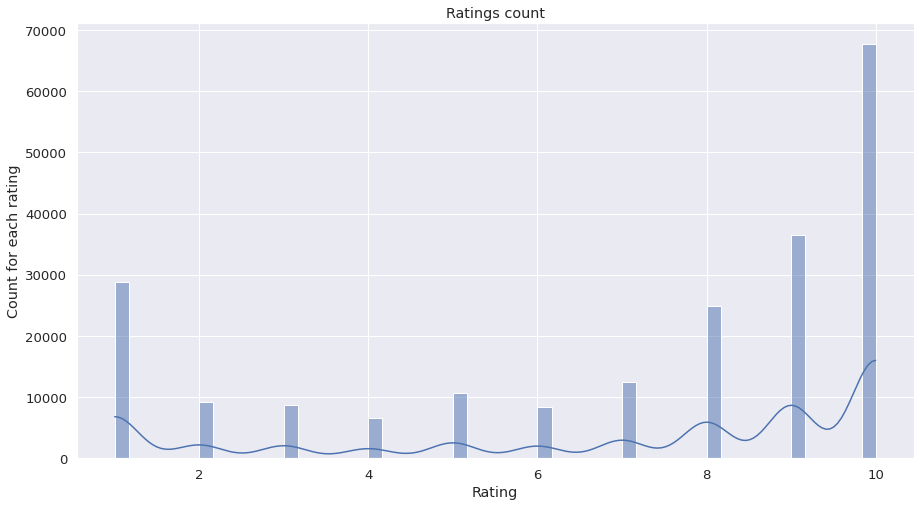

In [ ]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

fig = sns.histplot(data=df_data, x="rating", kde=True)
fig.set_title("Ratings count")
fig.set_xlabel("Rating")
fig.set_ylabel("Count for each rating");

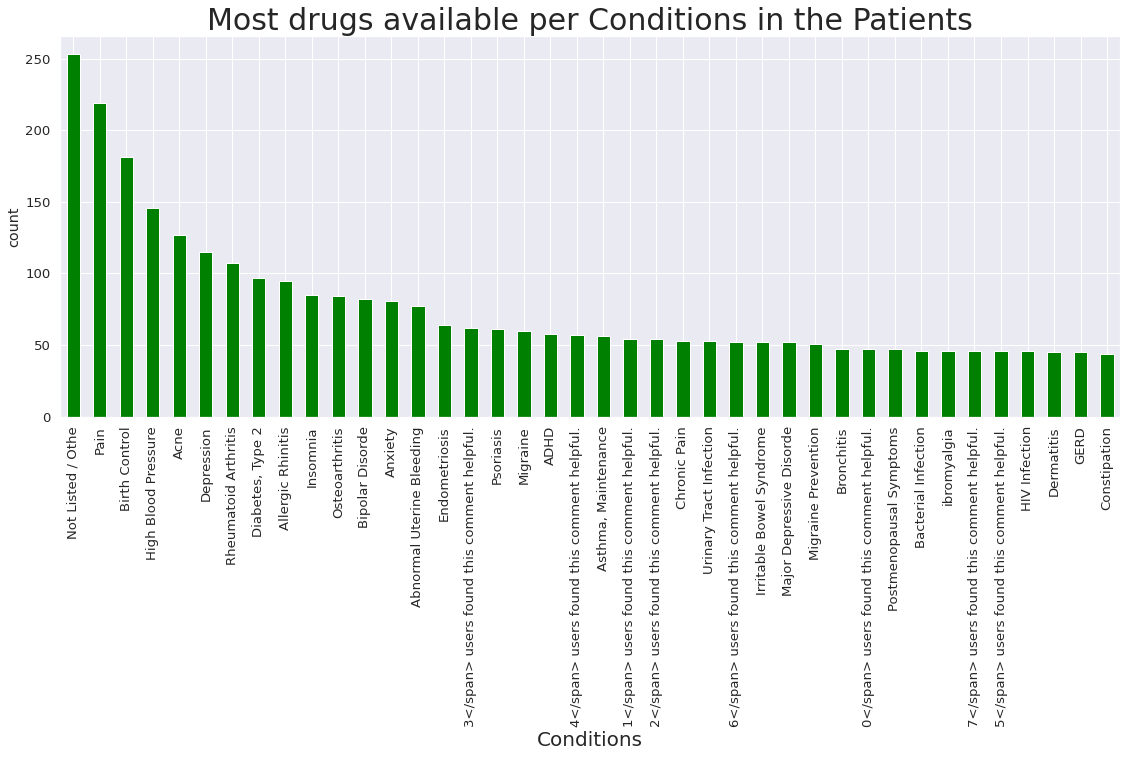

In [ ]:
df_data.groupby(['condition'])['drugname'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'green')
plt.title('Most drugs available per Conditions in the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

In [ ]:
# now extracting year from date
df_data['year'] = df_data['date'].dt.year

# extracting the month from the date
df_data['month'] = df_data['date'].dt.month

# extracting the days from the date
df_data['day'] = df_data['date'].dt.day

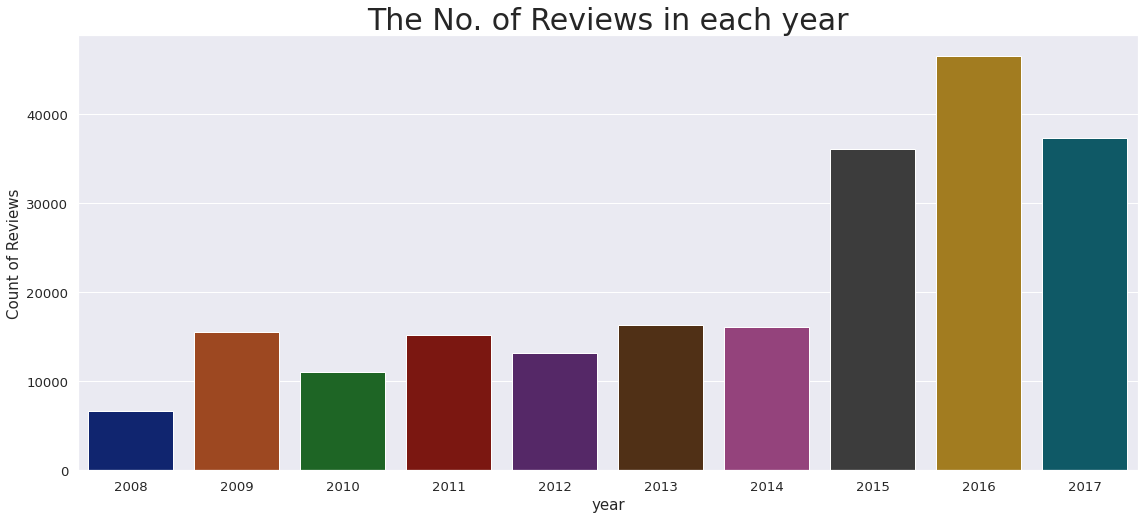

In [ ]:
plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(df_data['year'], palette ='dark')
plt.title('The No. of Reviews in each year', fontsize = 30)
plt.xlabel('year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

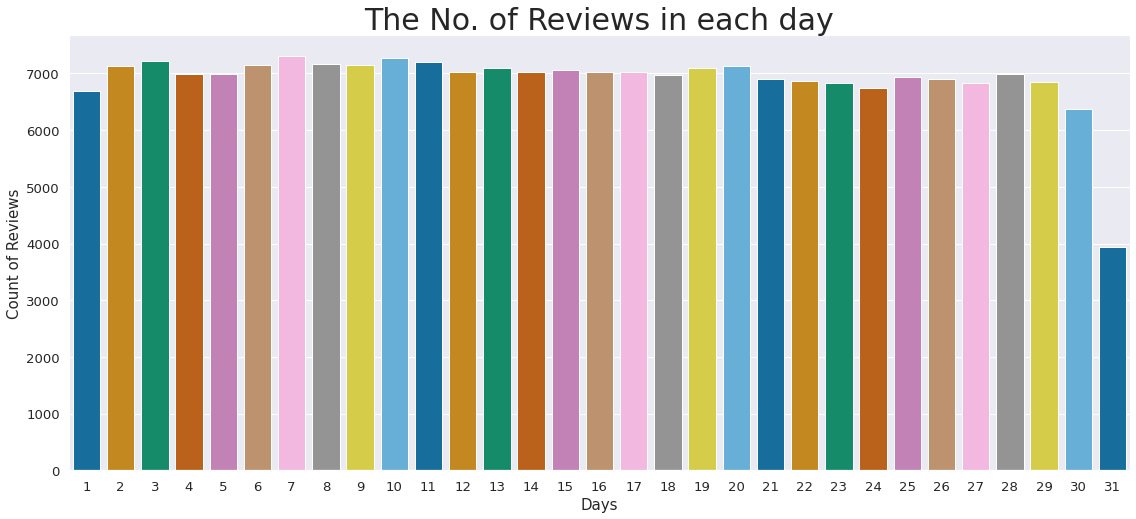

In [ ]:
plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(df_data['day'], palette ='colorblind')
plt.title('The No. of Reviews in each day', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

# Correlation Plot

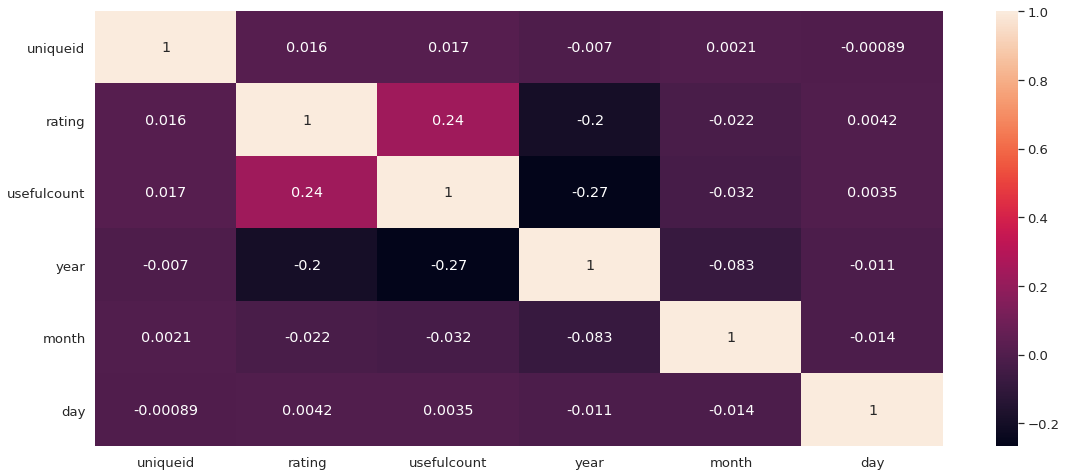

In [ ]:
sns.heatmap(df_data.corr(),annot=True)

In [ ]:
df_data.reset_index(drop=True,inplace=True)

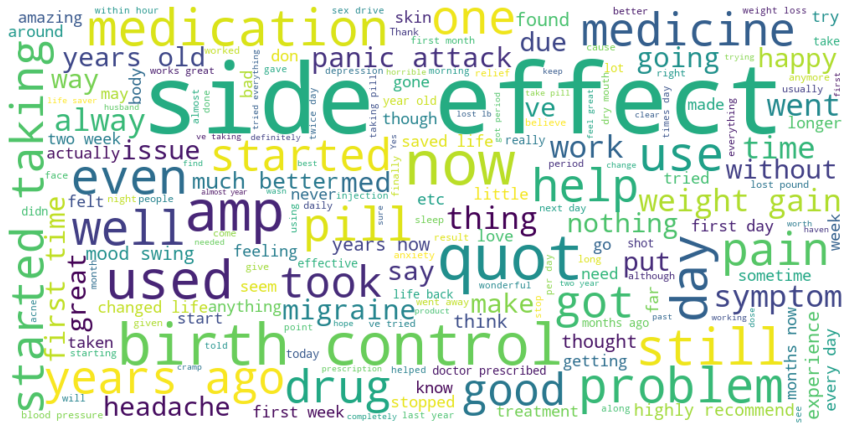

In [ ]:
# Word cloud of the reviews with rating equal to 10

df_rate_ten = df_data.loc[df_data.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

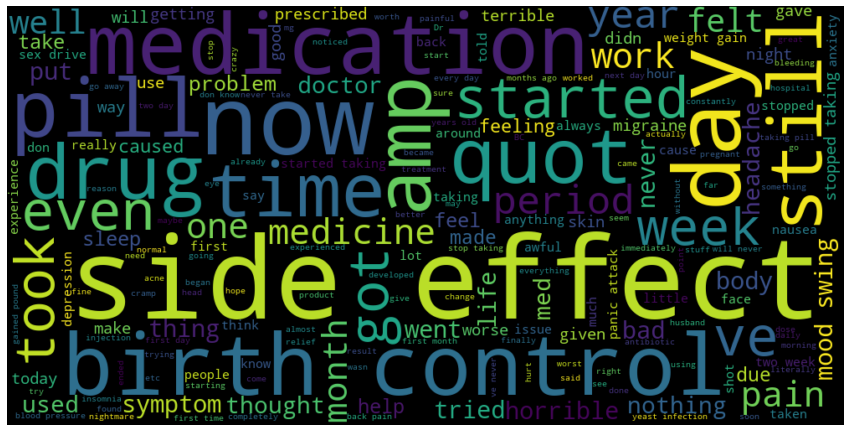

In [ ]:
# Word cloud of the reviews with rating equal to 1

df_rate_one = df_data.loc[df_data.rating == 1, 'review']
k1 = (' '.join(df_rate_one))

wordcloud = WordCloud(width = 1000, height = 500).generate(k1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

### Text Preprocessing for Review Column

In [ ]:
#single function for preprocessing using spacy but this is little slow
'''
def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


df_data['review_clean'] = df_data['review'].apply(normalize, lowercase=True, remove_stopwords=True)
'''


'\ndef normalize(comment, lowercase, remove_stopwords):\n    if lowercase:\n        comment = comment.lower()\n    comment = nlp(comment)\n    lemmatized = list()\n    for word in comment:\n        lemma = word.lemma_.strip()\n        if lemma:\n            if not remove_stopwords or (remove_stopwords and lemma not in stops):\n                lemmatized.append(lemma)\n    return " ".join(lemmatized)\n\n\ndf_data[\'review_clean\'] = df_data[\'review\'].apply(normalize, lowercase=True, remove_stopwords=True)\n'

In [ ]:
lst = df_data['review'].tolist()
matched_list = [ele for ele in lst if '&#039' in ele]
print('no of rows with "&#039" character are ',len(matched_list))


no of rows with "&#039" character are  133540


*By analyzing the review data we can observe that there is junk keyword which is repeated in more than half of the data but if we observe the context in which it appears, we can tell that its a quote " ' "*

#### converting the junk keyword

In [ ]:
df_data['review'] = df_data['review'].str.replace('&#039;',"'")

In [ ]:
lst = df_data['review'].tolist()
matched_list = [ele for ele in lst if '&#039' in ele]
print(len(matched_list))
matched_list

0


[]

In [ ]:
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "doesn’t": "does not", "don't": "do not", "don’t": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not","might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y’all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "ain’t": "am not", "aren’t": "are not",
    "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have",
    "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
    "i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
    "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
    "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
    "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
    "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",
    "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",
    "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "so’s": "so is",
    "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would", "there’d’ve": "there would have",
    "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", "they’ll’ve": "they will have",
    "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
    "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
    "what’ll’ve": "what will have", "what’re": "what are", "what’s": "what is", "what’ve": "what have", "when’s": "when is",
    "when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will",
    "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have","why’s": "why is", "why’ve": "why have", "will’ve": "will have",
    "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
    "y’all": "you all", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are",
    "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
    "you’re": "you are", "you’re": "you are", "you’ve": "you have"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


df_data['review_clean'] = df_data['review'].apply(expand_contractions)

In [ ]:
count = 0
def normalize_punc_lemmatize(text):
    global count
    count = count+1
    #normalizing the text by lowering to same case
    text = text.lower()
    #Removing the punctuations
    text_p = "".join([char for char in text if char not in string.punctuation])
    #Lemmatizing the text
    doc = nlp(text_p)
    sen = " ".join([token.lemma_ if token.lemma_ != '-PRON-' else str(token) for token in doc])
    #print(count)
    return sen


df_data['review_clean'] = df_data['review_clean'].apply(normalize_punc_lemmatize)

In [ ]:
df_data

,uniqueid,drugname,condition,review,rating,date,usefulcount,year,month,day,review_clean
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,5,20,it have no side effect i take it in combinatio...
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,4,27,my son be halfway through his fourth week of i...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,12,14,i use to take another oral contraceptive which...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,11,3,this be my first time use any form of birth co...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,11,27,suboxone have completely turn my life around ...
...,...,...,...,...,...,...,...,...,...,...,...
213864,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,2014-09-13,43,2014,9,13,i have take tamoxifen for 5 year side effect b...
213865,140714,Escitalopram,Anxiety,"""I've been taking Lexapro (escitaploprgram) si...",9,2016-10-08,11,2016,10,8,i have be take lexapro escitaploprgram since f...
213866,130945,Levonorgestrel,Birth Control,"""I'm married, 34 years old and I have no kids....",8,2010-11-15,7,2010,11,15,i be marry 34 year old and i have no kid take ...
213867,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,2011-11-28,20,2011,11,28,i be prescribe nucynta for severe neckshoulder...


In [ ]:
def preprocess(text):    
    
    #text_p = "".join([char for char in text if char not in string.punctuation])
    
    words = word_tokenize(text)    
    
    filtered_words = [word for word in words if word not in stop_words]
    
    #porter = PorterStemmer()
    #stemmed = [porter.stem(word) for word in filtered_words]
    
    #pos = pos_tag(filtered_words)
    final_string = " ".join(filtered_words)
    
    return final_string

df_data['review_clean'] = df_data['review_clean'].apply(preprocess)

### Feature Engineering

In [ ]:
# Sentiment polarity of the reviews
def sentiment(review):
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

df_data['sentiment'] = sentiment(df_data['review'])
df_data['sentiment_processed'] = sentiment(df_data['review_clean'])

In [ ]:
np.corrcoef(df_data['sentiment'], df_data['rating'])

array([[1.       , 0.3483115],
       [0.3483115, 1.       ]])

In [ ]:
np.corrcoef(df_data['sentiment_processed'], df_data['rating'])

array([[1.        , 0.36753024],
       [0.36753024, 1.        ]])

*As we can see there is no much difference in correlation coef between rating - review and rating - cleaned review / seems like we have not lost more of the important data*

In [ ]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,year,month,day,review_clean,sentiment,sentiment_processed
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,5,20,no side effect take combination bystolic 5 mg ...,0.000000,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,4,27,son halfway fourth week intuniv become concern...,0.168333,0.129722
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,12,14,use take another oral contraceptive 21 pill cy...,0.067210,0.078485
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,11,3,first time use form birth control glad go patc...,0.179545,0.357143
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,11,27,suboxone completely turn life around feel heal...,0.194444,0.242333


In [ ]:
df_data['review'].iloc[0]

'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

In [ ]:
df_data['review_clean'].iloc[0]

'no side effect take combination bystolic 5 mg fish oil'

In [ ]:
#Word count in each review
df_data['word_count']=df_data["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
df_data['unique_word_count']=df_data["review_clean"].apply(lambda x: len(set(str(x).split())))

#punctuation count
df_data["count_punc"] = df_data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_data["upper_word_count"] = df_data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_data["title_word_count"] = df_data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_data["stopword_count"] = df_data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#mean length of the words
df_data["mean_word_len"] = df_data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
df_data['mean_word_len'] = df_data['mean_word_len'].fillna(0)

In [ ]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,year,month,day,review_clean,sentiment,sentiment_processed,word_count,unique_word_count,count_punc,upper_word_count,title_word_count,stopword_count,mean_word_len
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,5,20,no side effect take combination bystolic 5 mg ...,0.000000,0.000000,10,10,3,1,6,6,4.500000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,4,27,son halfway fourth week intuniv become concern...,0.168333,0.129722,67,56,23,2,13,68,5.134328
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,12,14,use take another oral contraceptive 21 pill cy...,0.067210,0.078485,76,54,30,6,15,57,4.960526
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,11,3,first time use form birth control glad go patc...,0.179545,0.357143,44,31,13,4,9,43,4.568182
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,11,27,suboxone completely turn life around feel heal...,0.194444,0.242333,58,51,20,7,15,61,6.000000


In [ ]:
#label encoding for drugname and condition columns
label_encoder_drug= LabelEncoder()
label_encoder_condition = LabelEncoder()
df_data['drugname'] = label_encoder_drug.fit_transform(df_data['drugname'])
df_data['condition'] = label_encoder_condition.fit_transform(df_data['condition'])

In [ ]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,year,month,day,review_clean,sentiment,sentiment_processed,word_count,unique_word_count,count_punc,upper_word_count,title_word_count,stopword_count,mean_word_len
0,206461,3421,480,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,5,20,no side effect take combination bystolic 5 mg ...,0.000000,0.000000,10,10,3,1,6,6,4.500000
1,95260,1536,80,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,4,27,son halfway fourth week intuniv become concern...,0.168333,0.129722,67,56,23,2,13,68,5.134328
2,92703,1983,175,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,12,14,use take another oral contraceptive 21 pill cy...,0.067210,0.078485,76,54,30,6,15,57,4.960526
3,138000,2446,175,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,11,3,first time use form birth control glad go patc...,0.179545,0.357143,44,31,13,4,9,43,4.568182
4,35696,553,593,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,11,27,suboxone completely turn life around feel heal...,0.194444,0.242333,58,51,20,7,15,61,6.000000


In [ ]:
# Giving the Sentiment according to the ratings
df_data['sentiment_rate'] = df_data['rating'].apply(lambda x: 1 if x > 5 else 0)

In [ ]:
df_data.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount,year,month,day,review_clean,sentiment,sentiment_processed,word_count,unique_word_count,count_punc,upper_word_count,title_word_count,stopword_count,mean_word_len,sentiment_rate
0,206461,3421,480,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,5,20,no side effect take combination bystolic 5 mg ...,0.000000,0.000000,10,10,3,1,6,6,4.500000,1
1,95260,1536,80,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,4,27,son halfway fourth week intuniv become concern...,0.168333,0.129722,67,56,23,2,13,68,5.134328,1
2,92703,1983,175,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,12,14,use take another oral contraceptive 21 pill cy...,0.067210,0.078485,76,54,30,6,15,57,4.960526,0
3,138000,2446,175,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,11,3,first time use form birth control glad go patc...,0.179545,0.357143,44,31,13,4,9,43,4.568182,1
4,35696,553,593,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,11,27,suboxone completely turn life around feel heal...,0.194444,0.242333,58,51,20,7,15,61,6.000000,1


### Model Building on all features

In [ ]:
X_train = df_data[df_data['uniqueid'].isin(df_train['uniqueID'])].filter(['condition','year','month','day','word_count', 'usefulcount',
                                                                          'sentiment_processed','unique_word_count','upper_word_count',
                                                                          'count_punc','title_word_count','stopword_count','mean_word_len'])
X_test = df_data[df_data['uniqueid'].isin(df_test['uniqueID'])].filter(['condition','year','month','day','word_count', 'usefulcount',
                                                                          'sentiment_processed','unique_word_count','upper_word_count',
                                                                          'count_punc','title_word_count','stopword_count','mean_word_len'])
y_train = df_data[df_data['uniqueid'].isin(df_train['uniqueID'])]['sentiment_rate']
y_test = df_data[df_data['uniqueid'].isin(df_test['uniqueID'])]['sentiment_rate']

In [ ]:
X_train.columns

Index(['condition', 'year', 'month', 'day', 'word_count', 'usefulcount',
       'sentiment_processed', 'unique_word_count', 'upper_word_count',
       'count_punc', 'title_word_count', 'stopword_count', 'mean_word_len'],
      dtype='object')

In [ ]:
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=1,
        num_leaves=200,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        num_iterations=3000
)
model = clf.fit(X_train, y_train)

# Predictions
predictions_ml = model.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions_ml), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions_ml), '\n')

print (classification_report(y_test, predictions_ml))

The Accuracy of the model is :  0.8867610480447345 

The confusion Matrix is 

[[12838  3281]
 [ 2774 34578]] 

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     16119
           1       0.91      0.93      0.92     37352

    accuracy                           0.89     53471
   macro avg       0.87      0.86      0.86     53471
weighted avg       0.89      0.89      0.89     53471



In [58]:
xgb_clf = XGBClassifier()

model_xgb = xgb_clf.fit(X_train, y_train)

# Predictions
predictions_xgb = model_xgb.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions_xgb), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions_xgb), '\n')

print (classification_report(y_test, predictions_xgb))

The Accuracy of the model is :  0.7609732378298517 

The confusion Matrix is 

[[ 6559  9560]
 [ 3221 34131]] 

              precision    recall  f1-score   support

           0       0.67      0.41      0.51     16119
           1       0.78      0.91      0.84     37352

    accuracy                           0.76     53471
   macro avg       0.73      0.66      0.67     53471
weighted avg       0.75      0.76      0.74     53471



In [59]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train, y_train, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    m = model.fit(X_train,y_train)
    predictions_3 = m.predict(X_test)
    print (confusion_matrix(y_test, predictions_3), '\n')
    print (classification_report(y_test, predictions_3))
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: ignored

### n-gram Model Building on review column

In [60]:
df_data.review_clean

0         no side effect take combination bystolic 5 mg ...
1         son halfway fourth week intuniv become concern...
2         use take another oral contraceptive 21 pill cy...
3         first time use form birth control glad go patc...
4         suboxone completely turn life around feel heal...
                                ...                        
213864    take tamoxifen 5 year side effect severe sweat...
213865    take lexapro escitaploprgram since february fi...
213866    marry 34 year old no kid take pill hassle deci...
213867    prescribe nucynta severe neckshoulder pain tak...
213868                                                 work
Name: review_clean, Length: 213869, dtype: object

In [61]:
X_train_features = df_data[df_data['uniqueid'].isin(df_train['uniqueID'])].filter(['review_clean'])
X_test_features = df_data[df_data['uniqueid'].isin(df_test['uniqueID'])].filter(['review_clean'])
y_train_ngram = df_data[df_data['uniqueid'].isin(df_train['uniqueID'])]['sentiment_rate']
y_test_ngram = df_data[df_data['uniqueid'].isin(df_test['uniqueID'])]['sentiment_rate']

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             ngram_range=(1,3),
                             max_features = 20000
                            )
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=2, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [63]:
%time X_train_ngram = vectorizer.fit_transform(X_train_features['review_clean']).astype(float)
%time X_test_ngram = vectorizer.fit_transform(X_test_features['review_clean']).astype(float)

CPU times: user 59.3 s, sys: 2.72 s, total: 1min 2s
Wall time: 1min 1s
CPU times: user 22.8 s, sys: 368 ms, total: 23.1 s
Wall time: 23.1 s


In [64]:
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=1,
        num_leaves=200,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        num_iterations=3000
)
model = clf.fit(X_train_ngram, y_train_ngram)

# Predictions
predictions_ngrams = model.predict(X_test_ngram)
print ("The Accuracy of the model is : ", accuracy_score(y_test_ngram, predictions_ngrams), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test_ngram, predictions_ngrams), '\n')

print (classification_report(y_test_ngram, predictions_ngrams))

The Accuracy of the model is :  0.6254979334592583 

The confusion Matrix is 

[[ 5485 10634]
 [ 9391 27961]] 

              precision    recall  f1-score   support

           0       0.37      0.34      0.35     16119
           1       0.72      0.75      0.74     37352

    accuracy                           0.63     53471
   macro avg       0.55      0.54      0.55     53471
weighted avg       0.62      0.63      0.62     53471



In [65]:
#predictions_ml

In [66]:
#predictions_ngrams

In [67]:
X_test['ml_pred'] = predictions_ml
X_test['ngrams_pred'] = predictions_ngrams

In [68]:
len(predictions_ml)

53471

In [69]:
df_test.shape

(53766, 7)

In [70]:
len(predictions_ngrams)

53471

# Combining Results from two models

In [71]:
X_test['final_pred'] = (X_test['ml_pred']+X_test['ngrams_pred'])/2*X_test['usefulcount']

In [72]:
X_test.columns

Index(['condition', 'year', 'month', 'day', 'word_count', 'usefulcount',
       'sentiment_processed', 'unique_word_count', 'upper_word_count',
       'count_punc', 'title_word_count', 'stopword_count', 'mean_word_len',
       'ml_pred', 'ngrams_pred', 'final_pred'],
      dtype='object')

In [73]:
X_test['drugname'] = df_data[df_data['uniqueid'].isin(df_test['uniqueID'])].drugname

In [74]:
drug_labels = X_test['drugname'].tolist()
condition_labels = X_test['condition'].tolist()
X_test.drugname = list(label_encoder_drug.inverse_transform(drug_labels))
X_test.condition = label_encoder_condition.inverse_transform(condition_labels)

# Drugname Predictions

In [75]:
con = input('enter a condition ')
X_test.groupby('condition').get_group(con).sort_values('final_pred',ascending = False).drop_duplicates('drugname',keep='first').head(5)[['drugname','usefulcount']]

enter a condition Birth Control


,drugname,usefulcount
189043,Etonogestrel,730
208164,Implanon,448
190396,NuvaRing,312
172605,Levonorgestrel,252
209520,Mirena,234


In [ ]:
X_test.head()

,condition,year,month,day,word_count,usefulcount,sentiment_processed,unique_word_count,upper_word_count,count_punc,title_word_count,stopword_count,mean_word_len,ml_pred,ngrams_pred,final_pred,drugname
0,Depression,2012,2,28,47,22,-0.300000,38,2,18,4,24,5.553191,1,0,11.0,Mirtazapine
1,"Crohn's Disease, Maintenance",2009,5,17,26,17,0.483333,25,0,9,4,20,4.807692,1,1,17.0,Mesalamine
2,Urinary Tract Infection,2017,9,29,3,3,0.333333,3,0,2,1,1,7.000000,1,1,3.0,Bactrim
3,Weight Loss,2017,3,5,81,35,0.189263,62,10,30,14,72,4.641975,1,0,17.5,Contrave
4,Birth Control,2015,10,22,84,4,0.209479,58,10,13,17,75,4.440476,1,1,4.0,Cyclafem 1 / 35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53761,"Breast Cancer, Prevention",2014,9,13,61,43,-0.077778,47,16,13,17,40,5.065574,1,1,43.0,Tamoxifen
53762,Anxiety,2016,10,8,87,11,0.036638,52,10,28,17,53,4.896552,1,1,11.0,Escitalopram
53763,Birth Control,2010,11,15,87,7,-0.081177,60,11,22,17,71,4.252874,1,0,3.5,Levonorgestrel
53764,Pain,2011,11,28,22,20,0.000000,18,4,7,5,14,4.727273,0,1,10.0,Tapentadol
